# Librerías

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install scikit-surprise
%pip install efficient-apriori

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [150]:
#from surprise.model_selection import train_test_split
#from surprise import Dataset, Reader, KNNBasic, accuracy
from efficient_apriori import apriori

# Lectura de Datos

In [151]:
df_aisles=pd.read_csv('my-google-drive-import/aisles.csv')
print(df_aisles.info(), '\n')
df_departments=pd.read_csv('my-google-drive-import/departments.csv')
print(df_departments.info(), '\n')
df_products=pd.read_csv('my-google-drive-import/products.csv')
print(df_products.info(), '\n')
df_orders=pd.read_csv('my-google-drive-import/orders.csv')
print(df_orders.info(), '\n')
df_order_prior=pd.read_csv('my-google-drive-import/order_products__prior.csv')
print(df_order_prior.info(), '\n')
df_order_train=pd.read_csv('my-google-drive-import/order_products__train.csv')
print(df_order_train.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 no

In [152]:
df12=pd.merge(df_aisles, df_products, how='inner', on='aisle_id')
df123=pd.merge(df12, df_departments, how='inner', on='department_id')
df1234=pd.merge(df_order_train, df123, how='inner', on='product_id')
df12345=pd.merge(df_orders, df1234, how='inner', on='order_id')

In [153]:
data=df12345.drop(['aisle_id', 'department_id', 'eval_set', 'order_number'], axis =1)

In [154]:
data.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle,product_name,department
0,1187899,1,4,8,14.0,196,1,1,soft drinks,Soda,beverages
1,1187899,1,4,8,14.0,25133,2,1,packaged cheese,Organic String Cheese,dairy eggs
2,1187899,1,4,8,14.0,38928,3,1,yogurt,0% Greek Strained Yogurt,dairy eggs
3,1187899,1,4,8,14.0,26405,4,1,paper goods,XL Pick-A-Size Paper Towel Rolls,household
4,1187899,1,4,8,14.0,39657,5,1,candy chocolate,Milk Chocolate Almonds,snacks


In [155]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int64  
 1   user_id                 1384617 non-null  int64  
 2   order_dow               1384617 non-null  int64  
 3   order_hour_of_day       1384617 non-null  int64  
 4   days_since_prior_order  1384617 non-null  float64
 5   product_id              1384617 non-null  int64  
 6   add_to_cart_order       1384617 non-null  int64  
 7   reordered               1384617 non-null  int64  
 8   aisle                   1384617 non-null  object 
 9   product_name            1384617 non-null  object 
 10  department              1384617 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 116.2+ MB
None


In [156]:
print(data.nunique())

order_id                  131209
user_id                   131209
order_dow                      7
order_hour_of_day             24
days_since_prior_order        31
product_id                 39123
add_to_cart_order             80
reordered                      2
aisle                        134
product_name               39123
department                    21
dtype: int64


In [157]:
display(data.describe())

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
count,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06,1.384617e+06
mean,1.706298e+06,1.031128e+05,2.701392e+00,1.357759e+01,1.706613e+01,2.555624e+04,8.758044e+00,5.985944e-01
std,9.897326e+05,5.948715e+04,2.167646e+00,4.238458e+00,1.042642e+01,1.412127e+04,7.423936e+00,4.901829e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.433700e+05,5.173200e+04,1.000000e+00,1.000000e+01,7.000000e+00,1.338000e+04,3.000000e+00,0.000000e+00
50%,1.701880e+06,1.029330e+05,3.000000e+00,1.400000e+01,1.500000e+01,2.529800e+04,7.000000e+00,1.000000e+00
75%,2.568023e+06,1.549590e+05,5.000000e+00,1.700000e+01,3.000000e+01,3.794000e+04,1.200000e+01,1.000000e+00
max,3.421070e+06,2.062090e+05,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,8.000000e+01,1.000000e+00


# Exploratory Data Analysis

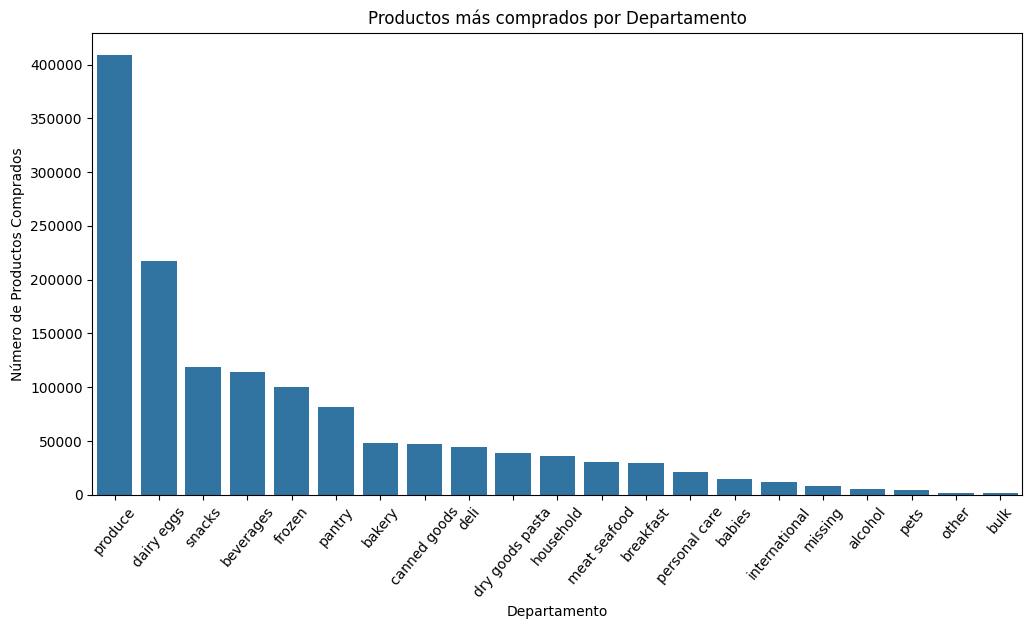

In [158]:
# 1 Products per department
# Conteo de productos por departamento
department_counts = data['department'].value_counts().sort_values(ascending=False)

# Gráfica
plt.figure(figsize=(12,6))
sns.barplot(x=department_counts.index, y=department_counts.values)
plt.xticks(rotation=50)
plt.title('Productos más comprados por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Número de Productos Comprados')
plt.show()

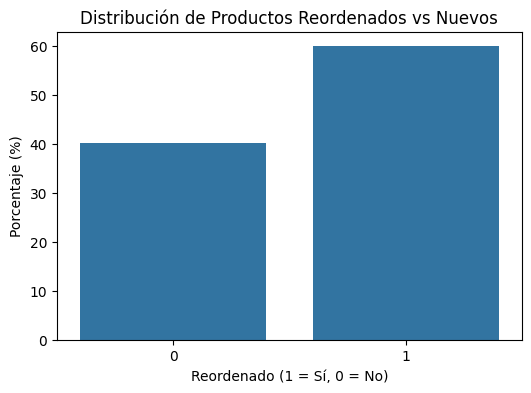

In [159]:
#2 Distribución de productos reordenados
# Distribución de la variable reordered
reordered_counts = data['reordered'].value_counts(normalize=True) * 100

# Gráfica
plt.figure(figsize=(6,4))
sns.barplot(x=reordered_counts.index, y=reordered_counts.values)
plt.title('Distribución de Productos Reordenados vs Nuevos')
plt.xlabel('Reordenado (1 = Sí, 0 = No)')
plt.ylabel('Porcentaje (%)')
plt.show()

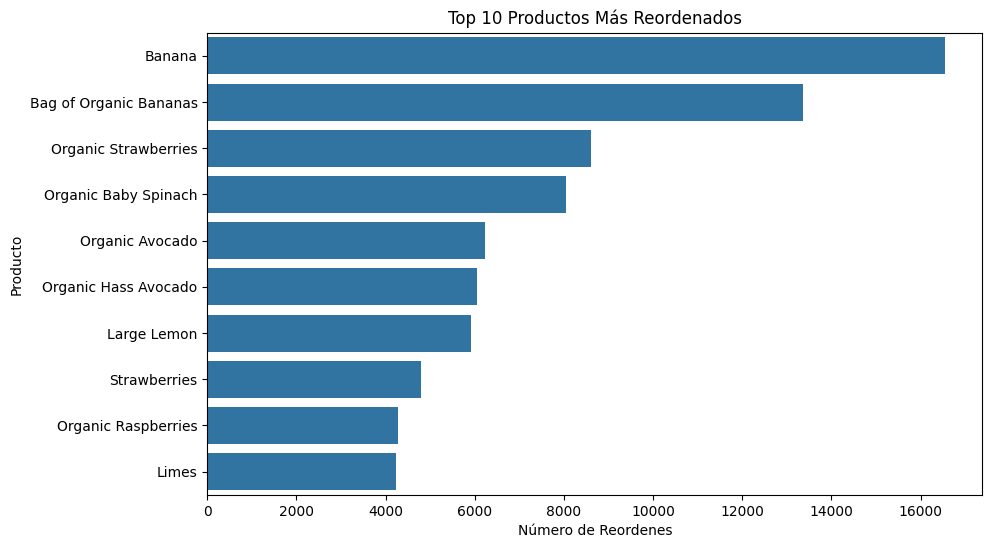

In [160]:
#3 Top 10 productos más reordenados
top_reordered_products = data[data['reordered'] == 1]['product_name'].value_counts().head(10)

# Gráfica
plt.figure(figsize=(10,6))
sns.barplot(x=top_reordered_products.values, y=top_reordered_products.index)
plt.title('Top 10 Productos Más Reordenados')
plt.xlabel('Número de Reordenes')
plt.ylabel('Producto')
plt.show()

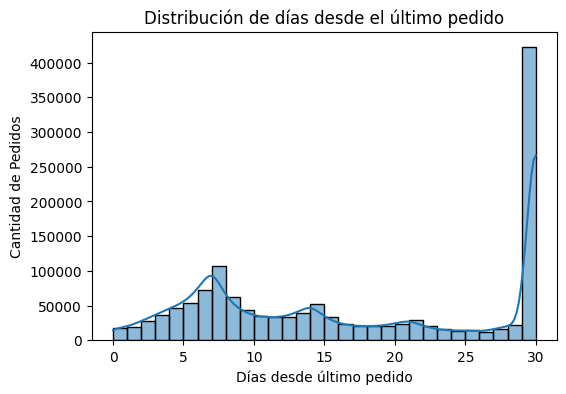

In [161]:
#4 Distribución de días desde el último pedido
days= data['days_since_prior_order'].dropna()

# Gráfica
plt.figure(figsize=(6,4))
sns.histplot(days, bins=30, kde=True)
plt.xticks(rotation=0)
plt.title('Distribución de días desde el último pedido')
plt.xlabel('Días desde último pedido')
plt.ylabel('Cantidad de Pedidos')
plt.show()

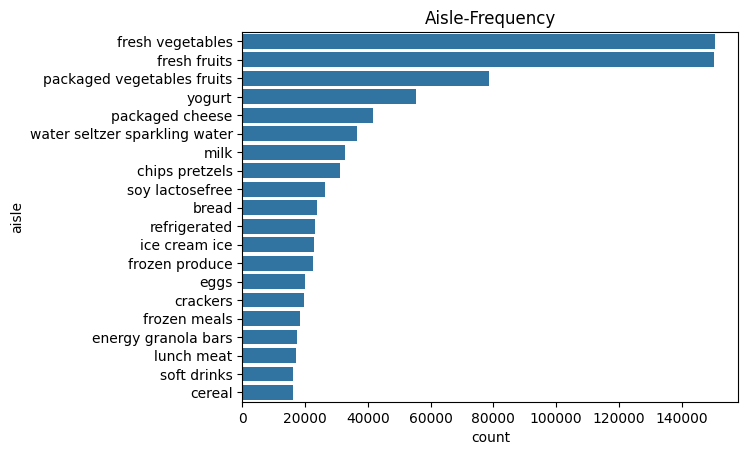

In [162]:
# 5 Top 20 pasillos de mayor frecuencia
sns.countplot(data.aisle, order=data.aisle.value_counts().index[:20])
plt.title('Aisle-Frequency')
plt.xticks(rotation=0)
plt.show()

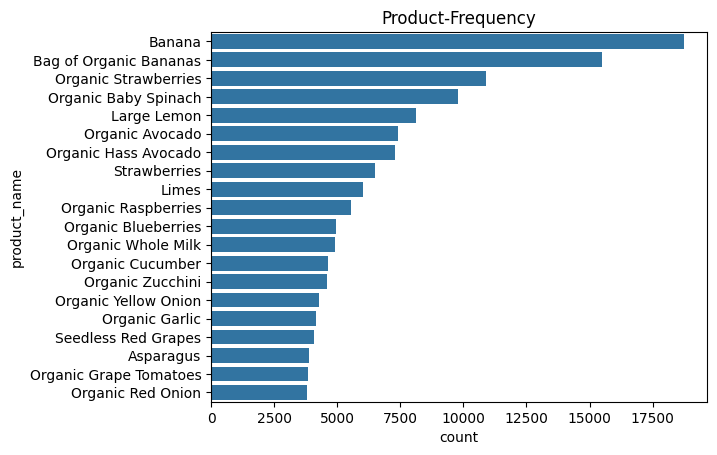

In [163]:
#6 Top 20 productos con mayor frecuencia
sns.countplot(data.product_name, order=data.product_name.value_counts().index[:20])
plt.title('Product-Frequency')
plt.xticks(rotation=0)
plt.show()

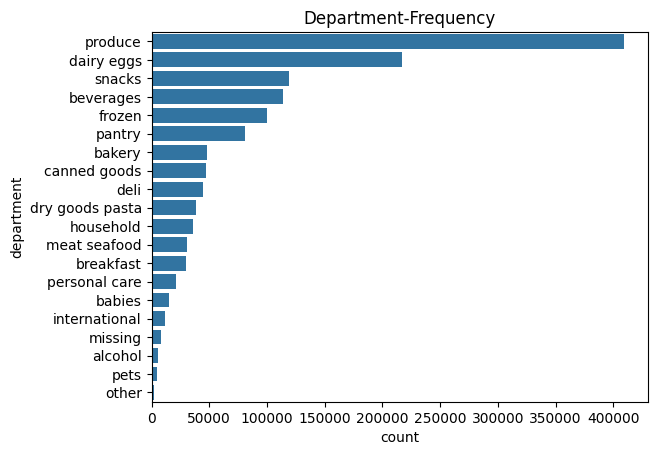

In [164]:
#7 Top 20 departamentos con mayor frecuencia
sns.countplot(data.department, order=data.department.value_counts().index[:20])
plt.title('Department-Frequency')
plt.xticks(rotation=0)
plt.show()

### Nulls

In [165]:
data.isnull().sum()

order_id                  0
user_id                   0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
aisle                     0
product_name              0
department                0
dtype: int64

### Outliers

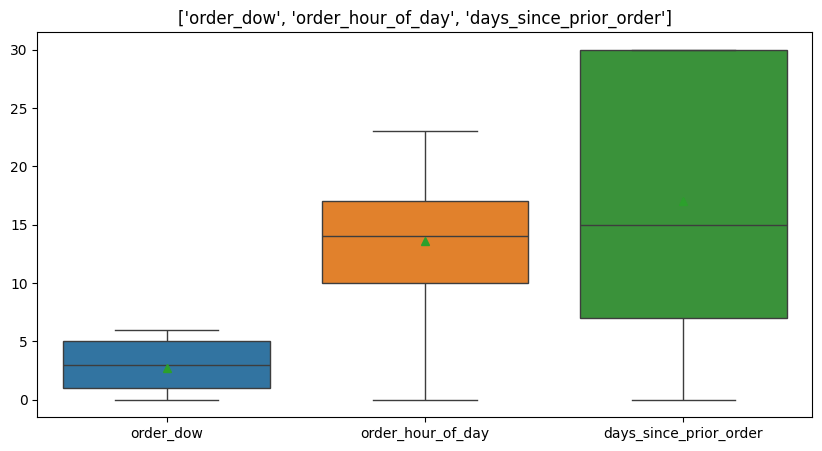

In [166]:
#Outliers
columns=[['order_dow', 'order_hour_of_day', 'days_since_prior_order']]
for col in columns:
  plt.figure(figsize=(10,5))
  sns.boxplot(data[col], showmeans=True)
  plt.title(col)
  plt.show()
  print('\n')

# Data preprocessing

In [167]:
data_vf=pd.get_dummies(data, prefix= 'Día',columns=['order_dow'], drop_first=False, dtype='int8')
data_vf.head()

,order_id,user_id,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle,product_name,department,Día_0,Día_1,Día_2,Día_3,Día_4,Día_5,Día_6
0,1187899,1,8,14.0,196,1,1,soft drinks,Soda,beverages,0,0,0,0,1,0,0
1,1187899,1,8,14.0,25133,2,1,packaged cheese,Organic String Cheese,dairy eggs,0,0,0,0,1,0,0
2,1187899,1,8,14.0,38928,3,1,yogurt,0% Greek Strained Yogurt,dairy eggs,0,0,0,0,1,0,0
3,1187899,1,8,14.0,26405,4,1,paper goods,XL Pick-A-Size Paper Towel Rolls,household,0,0,0,0,1,0,0
4,1187899,1,8,14.0,39657,5,1,candy chocolate,Milk Chocolate Almonds,snacks,0,0,0,0,1,0,0


In [168]:
data_vf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int64  
 1   user_id                 1384617 non-null  int64  
 2   order_hour_of_day       1384617 non-null  int64  
 3   days_since_prior_order  1384617 non-null  float64
 4   product_id              1384617 non-null  int64  
 5   add_to_cart_order       1384617 non-null  int64  
 6   reordered               1384617 non-null  int64  
 7   aisle                   1384617 non-null  object 
 8   product_name            1384617 non-null  object 
 9   department              1384617 non-null  object 
 10  Día_0                   1384617 non-null  int8   
 11  Día_1                   1384617 non-null  int8   
 12  Día_2                   1384617 non-null  int8   
 13  Día_3                   1384617 non-null  int8   
 14  Dí

In [169]:
data_vf_copy=data_vf.copy()
data_vf_copy = data_vf[data_vf['user_id'] < 100000]
data_vf_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672294 entries, 0 to 672293
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                672294 non-null  int64  
 1   user_id                 672294 non-null  int64  
 2   order_hour_of_day       672294 non-null  int64  
 3   days_since_prior_order  672294 non-null  float64
 4   product_id              672294 non-null  int64  
 5   add_to_cart_order       672294 non-null  int64  
 6   reordered               672294 non-null  int64  
 7   aisle                   672294 non-null  object 
 8   product_name            672294 non-null  object 
 9   department              672294 non-null  object 
 10  Día_0                   672294 non-null  int8   
 11  Día_1                   672294 non-null  int8   
 12  Día_2                   672294 non-null  int8   
 13  Día_3                   672294 non-null  int8   
 14  Día_4                   6

In [170]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        col_type2 = df[col].dtype.name
        
        if ((col_type != object) and (col_type2 != 'category')):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data Manipulation

In [171]:
data_vf2=reduce_mem_usage(data_vf)

Memory usage of dataframe is 114.88 MB
Memory usage after optimization is: 42.25 MB
Decreased by 63.2%


In [172]:
data_vf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   order_id                1384617 non-null  int32   
 1   user_id                 1384617 non-null  int32   
 2   order_hour_of_day       1384617 non-null  int8    
 3   days_since_prior_order  1384617 non-null  float16 
 4   product_id              1384617 non-null  int32   
 5   add_to_cart_order       1384617 non-null  int8    
 6   reordered               1384617 non-null  int8    
 7   aisle                   1384617 non-null  category
 8   product_name            1384617 non-null  category
 9   department              1384617 non-null  category
 10  Día_0                   1384617 non-null  int8    
 11  Día_1                   1384617 non-null  int8    
 12  Día_2                   1384617 non-null  int8    
 13  Día_3                   1384617 non-null  

In [173]:
#data_vf2=reduce_mem_usage(data_vf_copy)

In [174]:
# 1) Creamos un DataFrame sólo con user-item-rating
#ratings = data_vf2[['user_id','product_id','reordered']].copy()

# 2) Definir el Reader: aquí la escala va de 0 a 1
#reader = Reader(rating_scale=(0,1))

# 3) Cargamos en un Dataset de Surprise
#dataset = Dataset.load_from_df(ratings, reader)

# Modeling

In [175]:
#from surprise.model_selection import train_test_split
#traindata, testdata=train_test_split(dataset, test_size=0.25)

In [176]:
sim_options_user={'name': 'pearson_baseline', 'user_based': True, 'min_support': 1,'shrinkage'  : 100 }

In [177]:
sim_options_product={'name': 'pearson_baseline', 'user_based': False, 'min_support': 1,'shrinkage'  : 100}

In [178]:
#import surprise
#from surprise import Dataset, Reader, KNNBasic

#print(surprise.__version__)

In [179]:
#metodo_product=KNNBasic(sim_options=sim_options_product, verbose=True)
#metodo_product.fit(traindata)
#eval=metodo_product.test(testdata)
#print(accuracy.rmse(eval))

In [180]:
#metodo_user=KNNBasic(sim_options=sim_options_user, verbose=True)
#metodo_user.fit(traindata)
#eval=metodo_user.test(testdata)
#print(accuracy.rmse(eval))

In [181]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(data_vf2, test_size=0.3, random_state=100)

In [182]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(x_train)

NearestNeighbors(algorithm='brute', metric='cosine')

## Sistema Recomendación

In [183]:
from efficient_apriori import apriori

In [184]:
#Columnas relevantes 
df_orders = data_vf2[['order_id', 'add_to_cart_order', 'product_name']]

#Ordenar cada pedido por el campo add_to_cart_order
df_orders = df_orders.sort_values(['order_id', 'add_to_cart_order'])

In [185]:
transacciones= (
    df_orders
    .groupby('order_id')['product_name']
    .apply(list)
    .tolist()
)


### Efficient Apriori

In [186]:
conjuntos, reglas = apriori(transacciones,
                            min_support=0.01,
                            min_confidence=0.01)
filter(lambda regla:len(regla.lhs)==1,reglas) #devuelve el consecuente de las compras
for regla in reglas:
    print(regla)

{Organic Baby Spinach} -> {Bag of Organic Bananas} (conf: 0.229, supp: 0.017, lift: 1.937, conv: 1.143)
{Bag of Organic Bananas} -> {Organic Baby Spinach} (conf: 0.144, supp: 0.017, lift: 1.937, conv: 1.082)
{Organic Hass Avocado} -> {Bag of Organic Bananas} (conf: 0.332, supp: 0.018, lift: 2.813, conv: 1.320)
{Bag of Organic Bananas} -> {Organic Hass Avocado} (conf: 0.156, supp: 0.018, lift: 2.813, conv: 1.119)
{Organic Raspberries} -> {Bag of Organic Bananas} (conf: 0.321, supp: 0.014, lift: 2.720, conv: 1.299)
{Bag of Organic Bananas} -> {Organic Raspberries} (conf: 0.115, supp: 0.014, lift: 2.720, conv: 1.082)
{Organic Strawberries} -> {Bag of Organic Bananas} (conf: 0.282, supp: 0.023, lift: 2.392, conv: 1.229)
{Bag of Organic Bananas} -> {Organic Strawberries} (conf: 0.199, supp: 0.023, lift: 2.392, conv: 1.144)
{Large Lemon} -> {Banana} (conf: 0.265, supp: 0.016, lift: 1.859, conv: 1.167)
{Banana} -> {Large Lemon} (conf: 0.115, supp: 0.016, lift: 1.859, conv: 1.060)
{Limes} -> {

In [187]:
data_vf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   order_id                1384617 non-null  int32   
 1   user_id                 1384617 non-null  int32   
 2   order_hour_of_day       1384617 non-null  int8    
 3   days_since_prior_order  1384617 non-null  float16 
 4   product_id              1384617 non-null  int32   
 5   add_to_cart_order       1384617 non-null  int8    
 6   reordered               1384617 non-null  int8    
 7   aisle                   1384617 non-null  category
 8   product_name            1384617 non-null  category
 9   department              1384617 non-null  category
 10  Día_0                   1384617 non-null  int8    
 11  Día_1                   1384617 non-null  int8    
 12  Día_2                   1384617 non-null  int8    
 13  Día_3                   1384617 non-null  

In [188]:
print(data_vf2['department'].nunique())

21


In [189]:
print(data_vf2['aisle'].nunique())

134


### Data Manipulation for Clustering

In [190]:
data_cleaned=data_vf2.copy()

In [191]:
data_cleaned_vf=data_cleaned.drop(columns=['aisle', 
                                     'product_name',
                                     'order_id',
                                     'user_id',
                                     'product_id',
                                     'add_to_cart_order',
                                     ], axis=1)

In [192]:
data_cleaned_vf2=pd.get_dummies(data_cleaned_vf, dtype='int8')
data_cleaned_vf2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 31 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_hour_of_day           1384617 non-null  int8   
 1   days_since_prior_order      1384617 non-null  float16
 2   reordered                   1384617 non-null  int8   
 3   Día_0                       1384617 non-null  int8   
 4   Día_1                       1384617 non-null  int8   
 5   Día_2                       1384617 non-null  int8   
 6   Día_3                       1384617 non-null  int8   
 7   Día_4                       1384617 non-null  int8   
 8   Día_5                       1384617 non-null  int8   
 9   Día_6                       1384617 non-null  int8   
 10  department_alcohol          1384617 non-null  int8   
 11  department_babies           1384617 non-null  int8   
 12  department_bakery           1384617 non-null  int8   
 1

## Clustering

In [193]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Reducción de dimensionalidad

In [194]:
sc=StandardScaler()
data_cleaned_vf2_sc=sc.fit_transform(data_cleaned_vf2)
data_cleaned_vf2_sc

array([[-1.316 , -0.2942,  0.819 , ..., -0.0571, -0.6475, -0.3064],
       [-1.316 , -0.2942,  0.819 , ..., -0.0571, -0.6475, -0.3064],
       [-1.316 , -0.2942,  0.819 , ..., -0.0571, -0.6475, -0.3064],
       ...,
       [ 0.0997,  1.241 , -1.222 , ..., -0.0571, -0.6475, -0.3064],
       [ 0.0997,  1.241 , -1.222 , ..., -0.0571, -0.6475, -0.3064],
       [ 0.0997,  1.241 ,  0.819 , ..., -0.0571, -0.6475, -0.3064]],
      shape=(1384617, 31), dtype=float16)

#### PCA

In [195]:
pca=PCA(n_components=20)
data_cleaned_vf2_sc_pca=pca.fit_transform(data_cleaned_vf2_sc)
print(f"Varianza por componente: {pca.explained_variance_ratio_}", '\n')
print(f"Varianza acumulada: {pca.explained_variance_ratio_.cumsum()}")

Varianza por componente: [0.0450206  0.0408762  0.04060168 0.03844798 0.03777548 0.0369756
 0.03653501 0.03636895 0.0359936  0.0352219  0.03477337 0.0337956
 0.03367883 0.03335602 0.03331147 0.03316305 0.03304967 0.03293497
 0.03291538 0.03279639] 

Varianza acumulada: [0.0450206  0.0858968  0.12649847 0.16494645 0.20272194 0.23969754
 0.27623255 0.3126015  0.3485951  0.383817   0.41859037 0.45238597
 0.4860648  0.51942081 0.55273229 0.58589534 0.61894501 0.65187998
 0.68479536 0.71759175]


### K-Means

##### Técnica del codo

<function matplotlib.pyplot.show(close=None, block=None)>

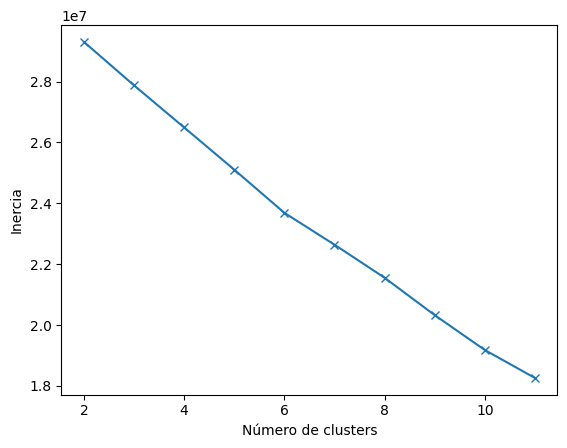

In [196]:
inercia=[]
for i in range(2,12):
    kmeans=KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_cleaned_vf2_sc_pca)
    inercia.append(kmeans.inertia_)
plt.plot(range(2,12),inercia, marker="x")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.show

#### Results

In [197]:
grupos = KMeans(n_clusters=6, random_state=42)
grupos.fit(data_cleaned_vf2_sc_pca)
print(grupos.labels_)

[5 4 4 ... 0 2 3]


C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


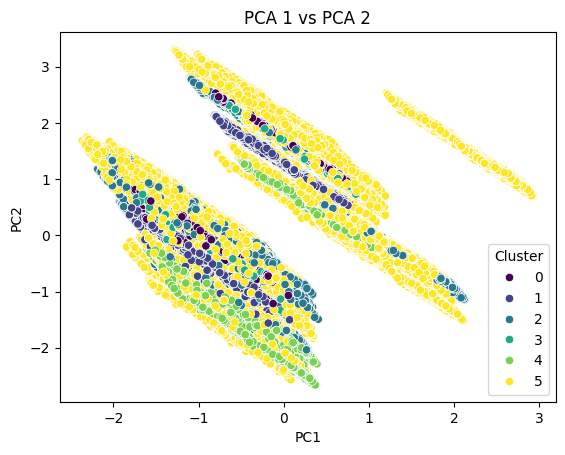

In [198]:
data_final=pd.DataFrame(data_cleaned_vf2_sc_pca, columns=['PC1','PC2','PC3','PC4','PC5',
                                                          'PC6','PC7','PC8','PC9','PC10',
                                                          'PC11','PC12','PC13','PC14','PC15',
                                                          'PC16','PC17','PC18','PC19','PC20'])
data_final['Cluster']=grupos.labels_
#PCA 1 y 2
sns.scatterplot(data=data_final, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('PCA 1 vs PCA 2')
plt.show()

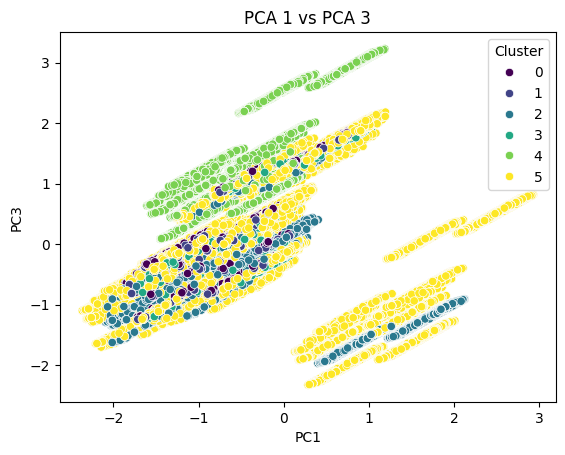

In [199]:
#PCA 1 y 3
sns.scatterplot(data=data_final, x='PC1', y='PC3', hue='Cluster', palette='viridis')
plt.title('PCA 1 vs PCA 3')
plt.show()

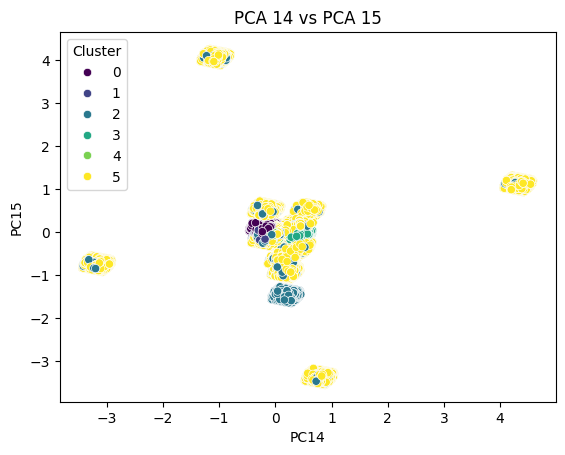

In [200]:
#PCA 14 y 15
sns.scatterplot(data=data_final, x='PC14', y='PC15', hue='Cluster', palette='viridis')
plt.title('PCA 14 vs PCA 15')
plt.show()

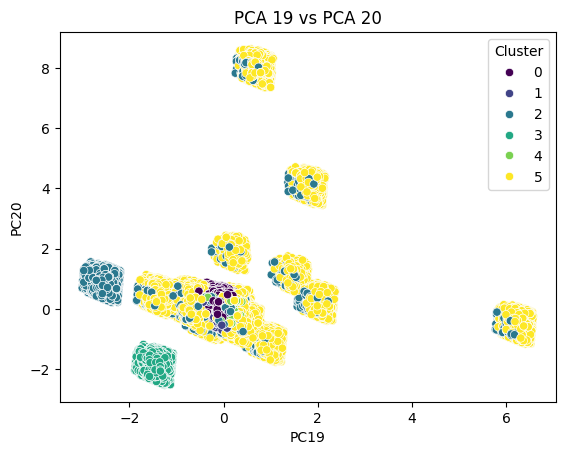

In [201]:
#PCA 19 y 20
sns.scatterplot(data=data_final, x='PC19', y='PC20', hue='Cluster', palette='viridis')
plt.title('PCA 19 vs PCA 20')
plt.show()

In [202]:
data_cleaned_vf2['Grupos']=grupos.labels_
data_segmentada=data_cleaned_vf2.groupby('Grupos')
for label, data in data_segmentada:
  print(f"Grupo: {label}")
  print(data.head(10))
  print("\n")

Grupo: 0
    order_hour_of_day  days_since_prior_order  reordered  Día_0  Día_1  Día_2  \
12                 11                    30.0          1      0      1      0   
27                 11                    30.0          1      0      1      0   
28                 11                    30.0          1      0      1      0   
29                 11                    30.0          0      0      1      0   
30                 11                    30.0          0      0      1      0   
31                 11                    30.0          1      0      1      0   
32                 11                    30.0          0      0      1      0   
33                 11                    30.0          0      0      1      0   
35                 11                    30.0          0      0      1      0   
36                 11                    30.0          0      0      1      0   

    Día_3  Día_4  Día_5  Día_6  ...  department_international  \
12      0      0      0      0  ..

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\LENOVO